# Developing Machine Learning Models for Predicting Atmospheric Emissions
### Scenario:
You have been engaged as a contract data scientist by Athana Data Science Services (ADSS), a small company specialising in the provision of data science consultancy services to public and private sector organisations. ADSS have just been awarded a contract by a government department (the Department of Environment) to help with the development of machine learning-based models for predicting atmospheric emissions (and pollution) from data gathered by various borough and county environment monitoring units. Your team leader wants you to assist with this project, and you will be required to carry out a number of tasks using the Anaconda/Scikit-Learn Python ML framework and its components.

### Datasets to be utilized for developing the ML models
Access the following URL:

https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory--laei--2019

The web page describes the various types of data held for monitored atmospheric emissions for the year 2019. Note that ADSS will ultimately be working on datasets compiled over a 50-year period, but you will be focusing only on a single year (2019), in the first instance, when developing the ML models.

### To complete this group project:
Carry out the following tasks

- Identify and describe in some detail at least 3 machine learning algorithms/techniques that you intend to use in your project.  Provide your reasons for selecting those ML methods.
- Specify the types of predictive insights you expect to glean from the data after you have applied your ML models. Your response should be based on actual inspection of the datasets and should be as specific as possible.
- Develop the respective ML models using your Jupyter notebook and Anaconda/Scikit-Learn toolkit to work on the datasets available on the website.
- Assess the performance of each model using suitable ML metrics and explain in detail any differences in model performance.
- Write a report, intended for interested stakeholders, that summarizes the work carried out for tasks 1 – 4, and which presents salient ML modelling results obtained by your group.

In [7]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO
from zipfile import ZipFile
import geopandas as gpd

from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

In [9]:
def download_and_extract_zip(url, extract_dir='./data'):
    """
    Download a zip file from a URL and extract its contents to a directory
    """
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)

    print(f"Downloading data from {url}...")
    response = requests.get(url)
    response.raise_for_status()

    with ZipFile(BytesIO(response.content)) as zip_file:
        zip_file.extractall(extract_dir)
        print(f"Files extracted to {extract_dir}")

    return True

In [12]:
emission_data_url = "https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/17d21cd1-892e-4388-9fea-b48c1b61ee3c/LAEI-2019-Emissions-Summary-including-Forecast.zip"
road_traffic_data_major_url = "https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/3a00296b-c88b-4de0-8336-b127034cc07b/laei-2019-major-roads-vkm-flows-speeds.zip"
road_traffic_data_minor_url = "https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/6ed20b0b-257b-4fda-9cf7-832c045d5c76/LAEI2019-nox-pm-co2-minor-roads-grid-emissions.zip"
road_traffic_data_cold_url = "https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/6defa131-f57e-4f86-921d-8d023c98155d/LAEI2019-nox-pm-cold-start-grid-emissions.zip"
concentration_data_url = "https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/f9f70e47-5683-4430-86e2-ffa2a50b31b1/LAEI2019-Concentrations-Data-CSV.zip"

In [11]:
download_and_extract_zip(emission_data_url, './data/emission')

Files extracted to ./data/emission


True

In [13]:
download_and_extract_zip(road_traffic_data_major_url, './data/road_traffic_major')
download_and_extract_zip(road_traffic_data_minor_url, './data/road_traffic_minor')
download_and_extract_zip(road_traffic_data_cold_url, './data/road_traffic_cold_start')
download_and_extract_zip(concentration_data_url, './data/concentration_data')

Files extracted to ./data/road_traffic_major
Files extracted to ./data/road_traffic_minor
Files extracted to ./data/road_traffic_cold_start
Files extracted to ./data/concentration_data


True

In [2]:
emission_data = pd.read_excel("./data/emission/LAEI-2019-Emissions-Summary-including-Forecast.xlsx", sheet_name="Emissions by Grid ID")

This dataset includes emissions of key pollutants NOx, PM10, PM2.5 and CO2, and a range of additional pollutants (SO2, CH4, VOC...) in tonnes/year for 2019 for each source category at a 1km grid square resolution (further split to follow all London borough boundaries). It includes emission summary tables for London boroughs and London zones (Central / Inner / Outer London).

## Basic Data Information 

In [5]:
emission_data.head()

,Year,Grid ID 2019,LAEI 1km2 ID,Easting,Northing,Borough,Zone,Main Source Category,Sector,Source,...,n2o,nh3,nmvoc,nox,pb,pcb,pm10,pm2.5,so2,Emissions Unit
0,2030,1,5910,510500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019183,0.019183,NaN,tonnes/annum
1,2030,2,5911,511500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.015719,0.015719,NaN,tonnes/annum
2,2030,3,5912,512500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019878,0.019878,NaN,tonnes/annum
3,2030,4,5915,515500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.020946,0.020946,NaN,tonnes/annum
4,2030,5,5916,516500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.020105,0.020105,NaN,tonnes/annum


In [3]:
emission_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699120 entries, 0 to 699119
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Year                  699120 non-null  int64  
 1   Grid ID 2019          699120 non-null  int64  
 2   LAEI 1km2 ID          699120 non-null  int64  
 3   Easting               699120 non-null  int64  
 4   Northing              699120 non-null  int64  
 5   Borough               699120 non-null  object 
 6   Zone                  699120 non-null  object 
 7   Main Source Category  699120 non-null  object 
 8   Sector                699120 non-null  object 
 9   Source                699120 non-null  object 
 10  bap                   162620 non-null  float64
 11  cd                    128020 non-null  float64
 12  c4h6                  186840 non-null  float64
 13  c6h6                  217980 non-null  float64
 14  ch4                   266420 non-null  float64
 15  

In [11]:
#for missing values
missing_data = emission_data.isnull().sum()
missing_percent = (missing_data / len(emission_data)) * 100

missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percent})

In [14]:
missing_info[missing_info['Missing Values'] > 0].sort_values('Missing Values', ascending=False)

,Missing Values,Percentage
hc,664520,95.050921
hcl,619540,88.617119
cd,571100,81.688408
pcb,564180,80.698593
hg,560720,80.203685
pb,560720,80.203685
nh3,536500,76.739329
bap,536500,76.739329
n2o,512280,73.274974
c4h6,512280,73.274974


## Descriptive statistics 

In [67]:
pollutants = ['nox', 'pm10', 'pm2.5', 'co2'] # consideing only main pollutants for initial analysis

emission_data[pollutants].describe()

,nox,pm10,pm2.5,co2
count,595656.000000,681820.000000,681820.000000,5.368360e+05
mean,0.363579,0.065826,0.029063,2.588404e+02
std,4.594794,0.561595,0.163715,4.152603e+03
min,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000e+00
50%,0.001510,0.000920,0.000562,8.800342e-01
75%,0.078821,0.020372,0.011918,5.747498e+01
max,1021.816850,132.712137,23.070241,1.764616e+06


The descriptive stats show that pollutant emissions (NOx, PM10, PM2.5, CO2) are highly skewed, with most values concentrated near zero but a few extreme outliers (like CO2 with peak value at 1.76 million tonnes/year).

# Exploratory Data Analysis

In [18]:
# plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

### Yearly Distribution of Records 

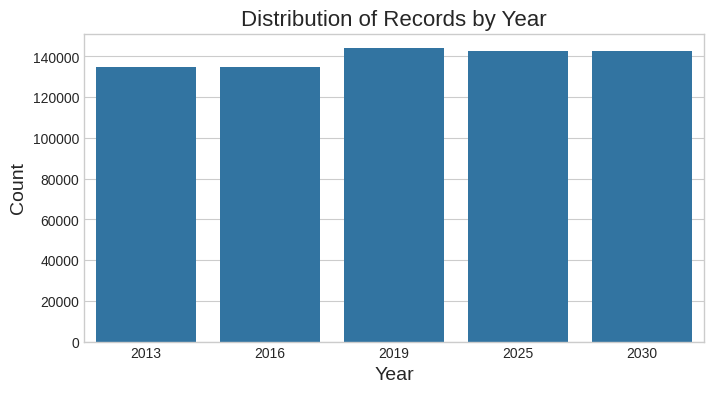

In [22]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Year', data=emission_data)
plt.title('Distribution of Records by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

This record counts confirm consistent data collection across years, with slightly higher counts in 2019, 2025, and 2030.

###  Analyze boroughs and zones 

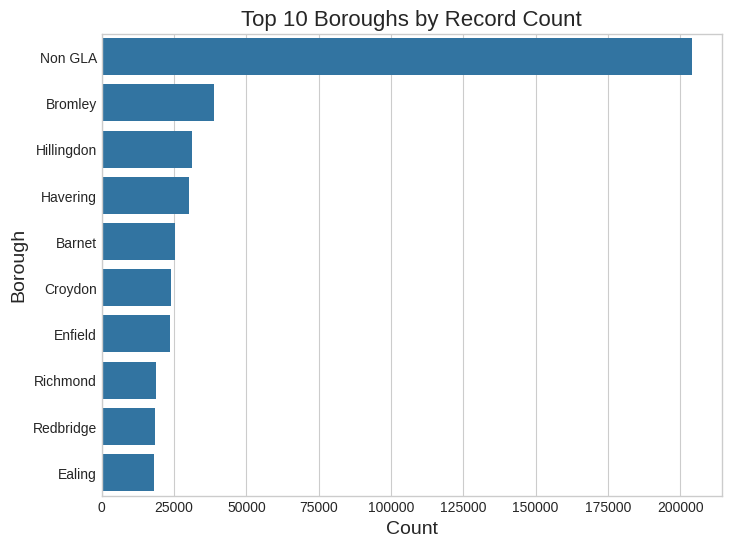

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(y='Borough', data=emission_data, 
               order=emission_data['Borough'].value_counts().iloc[:10].index)
plt.title('Top 10 Boroughs by Record Count')
plt.xlabel('Count')
plt.ylabel('Borough')
plt.show()

The bar plot shows the top 10 boroughs by record count, with `Non GLA` leading significantly, followed by `Bromley` and `Hillingdon`. This suggests a heavier focus on outer London areas for emissions data collection, likely due to larger geographic areas or higher emissions sources, compared to central boroughs like the City of London.

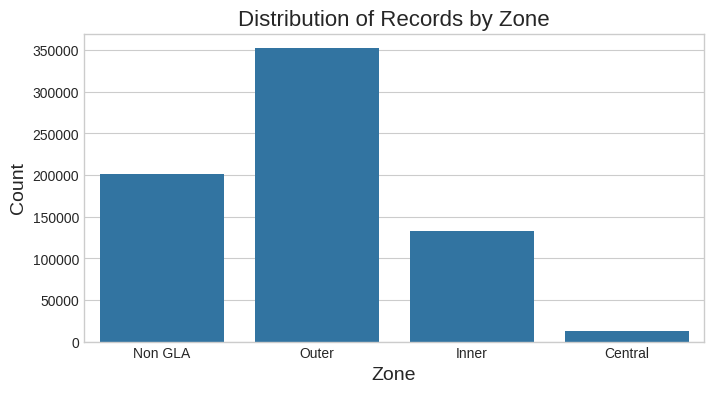

In [28]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Zone', data=emission_data)
plt.title('Distribution of Records by Zone')
plt.xlabel('Zone')
plt.ylabel('Count')
plt.show()

The bar plot highlights that most emissions data comes from Outer London, followed by Non GLA areas, with Inner and Central London having fewer records. This shows that the larger size of outer zones and more dispersed emissions sources compared to the denser, smaller central areas.

### Analyze source categories and sectors 

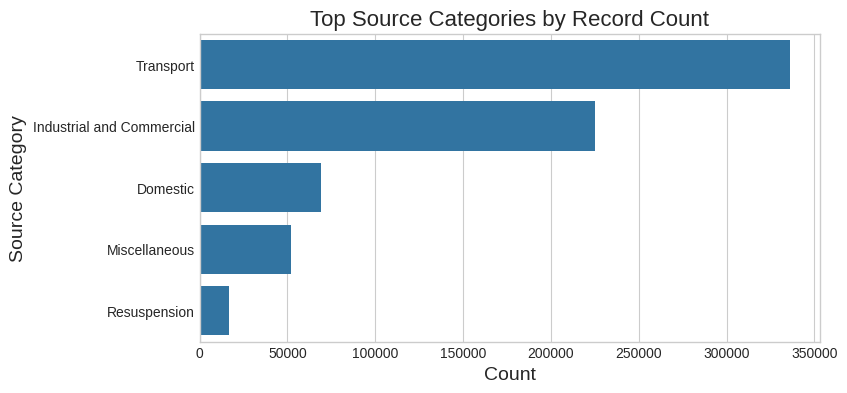

In [31]:
plt.figure(figsize=(8, 4))
sns.countplot(y='Main Source Category', data=emission_data,
               order=emission_data['Main Source Category'].value_counts().iloc[:10].index)
plt.title('Top Source Categories by Record Count')
plt.xlabel('Count')
plt.ylabel('Source Category')
plt.show()

The bar plot shows that `Transport` is the largest source of emissions, followed by `Industrial and Commercial` activities. `Domestic` and `Miscellaneous` sources contribute less, while `Resuspension` has the fewest records. This suggests transport and industrial sectors are the primary drivers of atmospheric emissions in the dataset.

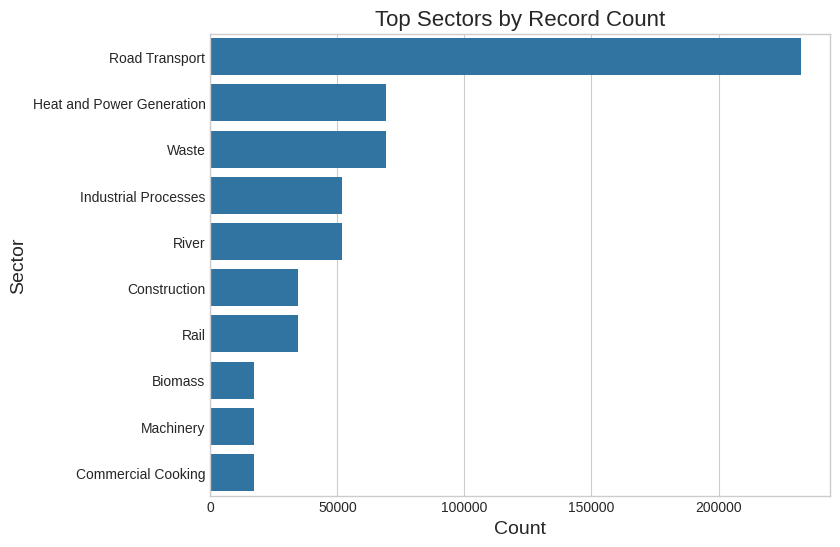

In [33]:
plt.figure(figsize=(8, 6))
sns.countplot(y='Sector', data=emission_data,
               order=emission_data['Sector'].value_counts().iloc[:10].index)
plt.title('Top Sectors by Record Count')
plt.xlabel('Count')
plt.ylabel('Sector')
plt.show()

The bar plot reveals `Road Transport` as the dominant sector for emissions, far outpacing others like `Heat and Power Generation` and `Waste`. Smaller contributors include sectors like `Aviation`, `Forestry`, and `Agriculture`. This emphasizes the significant impact of transportation on atmospheric pollution compared to other sectors.

### Statistical analysis of pollutants 

In [43]:
def analyze_pollutant(df, pollutant):
    
    data = df[~df[pollutant].isna()]
    
    print(f"\nAnalysis for {pollutant}:")
    print(f"Number of records: {len(data)}")
    print(f"Percentage of data available: {len(data)/len(df)*100:.2f}%")
    print(f"Min: {data[pollutant].min():.4f}")
    print(f"Max: {data[pollutant].max():.4f}")
    print(f"Mean: {data[pollutant].mean():.4f}")
    print(f"Median: {data[pollutant].median():.4f}")
    print(f"Standard deviation: {data[pollutant].std():.4f}")
    
    # checking for outliers using IQR method
    Q1 = data[pollutant].quantile(0.25)
    Q3 = data[pollutant].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[pollutant] < lower_bound) | (data[pollutant] > upper_bound)]
    print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(data)*100:.2f}%)")
    
    # box plot
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data[pollutant])
    plt.title(f'Box Plot of {pollutant}')
    plt.ylabel(pollutant)
    
    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(data[pollutant], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {pollutant}')
    plt.tight_layout()
    plt.show()


Analysis for nox:
Number of records: 595656
Percentage of data available: 85.20%
Min: 0.0000
Max: 1021.8169
Mean: 0.3636
Median: 0.0015
Standard deviation: 4.5948
Number of outliers: 112878 (18.95%)


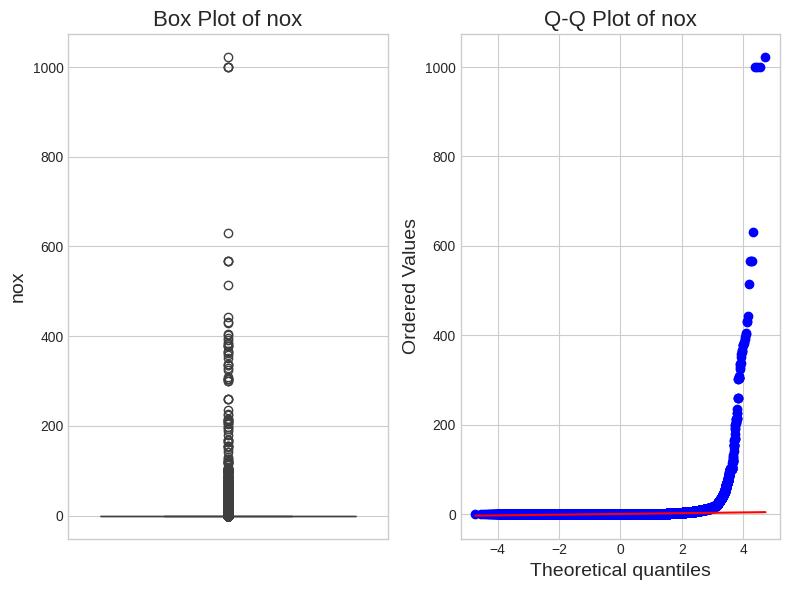


-----------------------------


Analysis for pm10:
Number of records: 681820
Percentage of data available: 97.53%
Min: 0.0000
Max: 132.7121
Mean: 0.0658
Median: 0.0009
Standard deviation: 0.5616
Number of outliers: 114454 (16.79%)


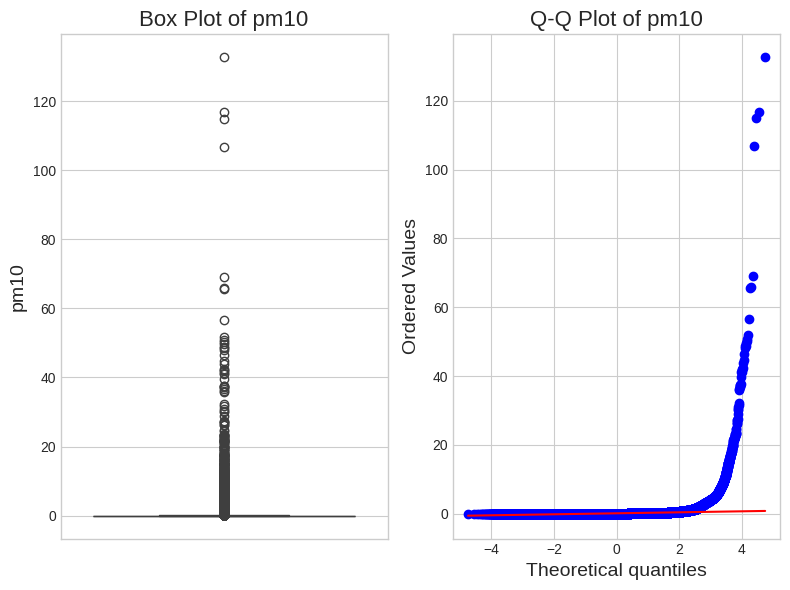


-----------------------------


Analysis for pm2.5:
Number of records: 681820
Percentage of data available: 97.53%
Min: 0.0000
Max: 23.0702
Mean: 0.0291
Median: 0.0006
Standard deviation: 0.1637
Number of outliers: 113518 (16.65%)


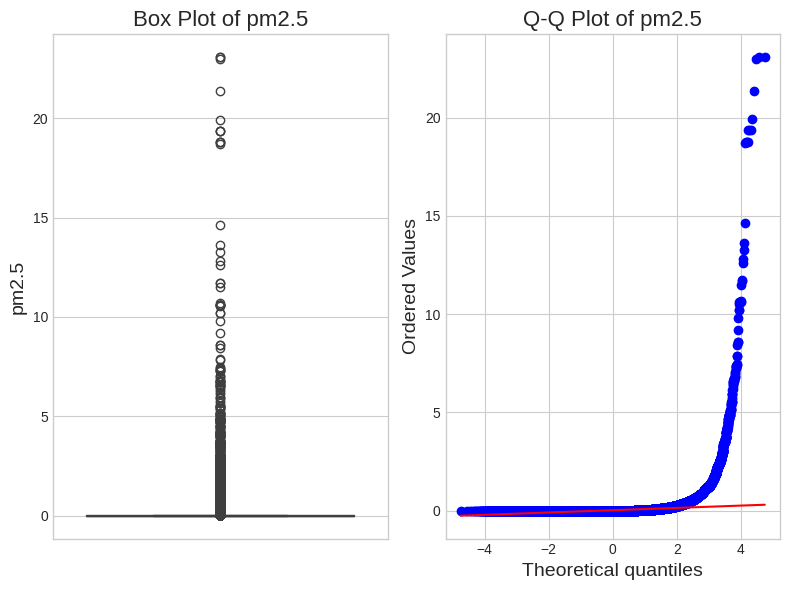


-----------------------------


Analysis for co2:
Number of records: 536836
Percentage of data available: 76.79%
Min: 0.0000
Max: 1764616.3000
Mean: 258.8404
Median: 0.8800
Standard deviation: 4152.6028
Number of outliers: 96307 (17.94%)


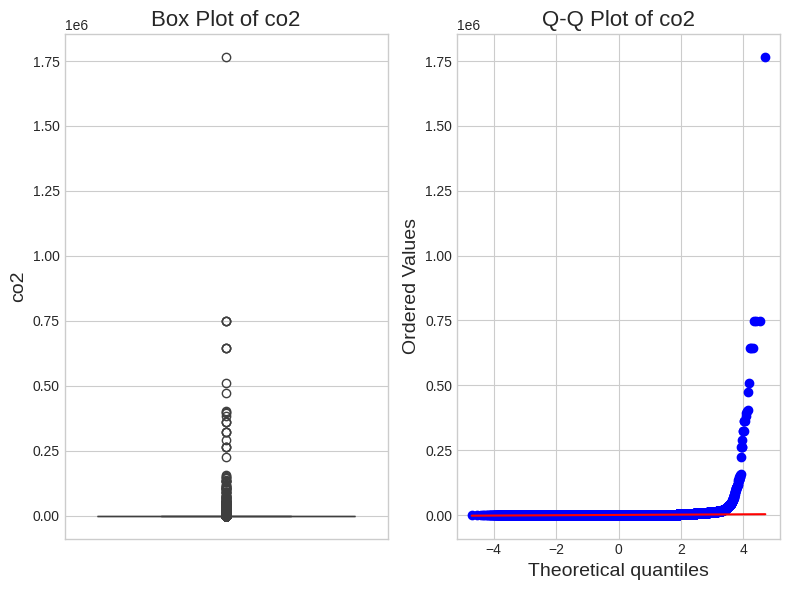


-----------------------------



In [44]:
pollutants = ['nox', 'pm10', 'pm2.5', 'co2']

for pollutant in pollutants:
    analyze_pollutant(emission_data, pollutant)
    print("\n-----------------------------\n")

- The analysis shows that while most pollutant data (NOx, PM10, PM2.5, CO2) is fairly complete; CO2 has the most missing values (23.21%). 
- All pollutants have highly skewed distributions, with medians close to zero but extreme outliers; particularly CO2, which peaks at over 1.76 million tonnes/year. 
- Outliers make up a significant portion of each dataset, ranging from about 16% to 19%, highlighting the extreme nature of emissions data and the **need for careful handling in model training**.

### Pollutant analysis by year 

In [45]:
def analyze_pollutant_by_year(df, pollutant):
    data = df[~df[pollutant].isna()]
    
    #calculate stats- grouped by year
    year_stats = data.groupby('Year')[pollutant].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
    print(f"\n{pollutant} statistics by year:")
    print(year_stats)
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='Year', y='mean', data=year_stats, marker='o', linewidth=2)
    
    # error bars based on std dev.
    plt.errorbar(year_stats['Year'], 
                 year_stats['mean'], 
                 yerr=year_stats['std'], 
                 fmt='none', 
                 capsize=5, 
                 ecolor='gray', 
                 alpha=0.5)
    
    plt.title(f'Mean {pollutant} Emissions by Year with Standard Deviation')
    plt.xlabel('Year')
    plt.ylabel(f'Mean {pollutant} (tonnes/year)')
    plt.xticks(year_stats['Year'])
    plt.tight_layout()
    plt.show()


nox statistics by year:
   Year      mean    median       std  min          max
0  2013  0.529434  0.002352  3.806709  0.0   443.909781
1  2016  0.484606  0.002064  5.186188  0.0  1021.816850
2  2019  0.368503  0.001688  4.747844  0.0  1000.194271
3  2025  0.252474  0.001319  4.579019  0.0  1000.194271
4  2030  0.201307  0.001028  4.529735  0.0  1000.194271


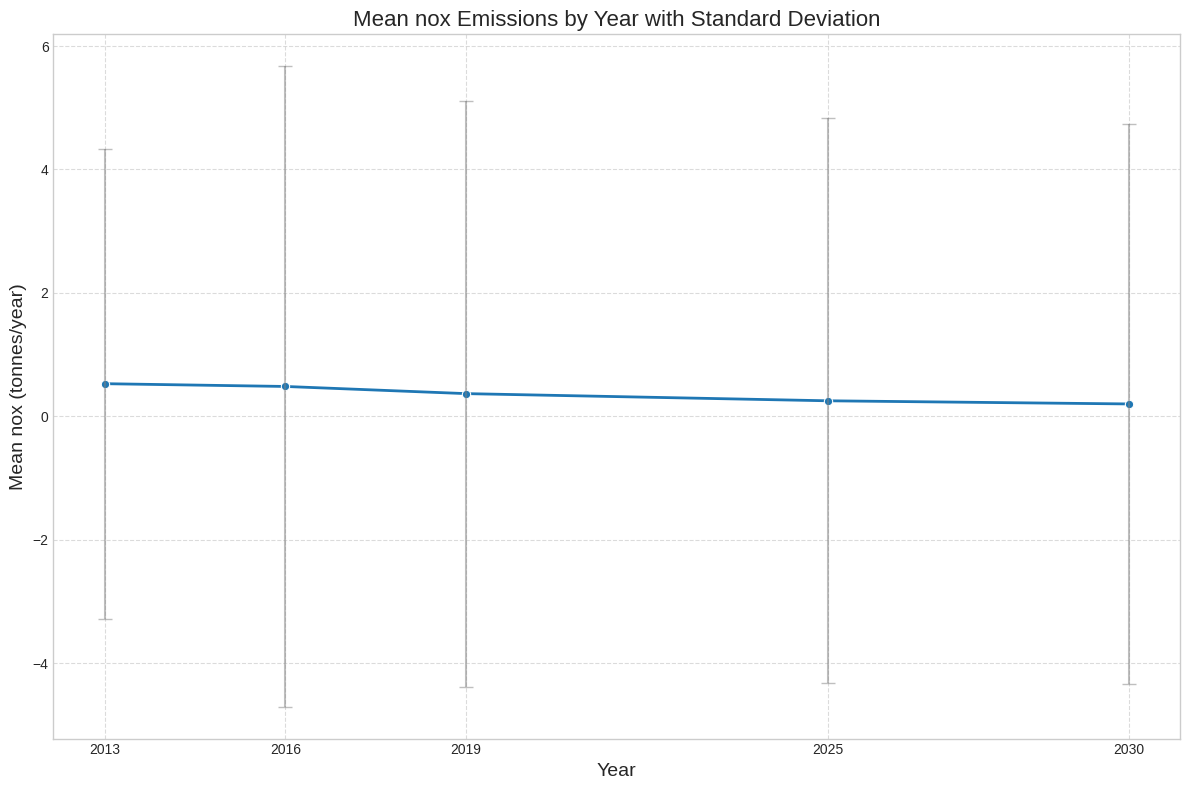


pm10 statistics by year:
   Year      mean    median       std  min         max
0  2013  0.073391  0.000443  0.672209  0.0  132.712137
1  2016  0.072582  0.000615  0.661273  0.0  116.908248
2  2019  0.065203  0.000799  0.693626  0.0  114.906839
3  2025  0.061066  0.001378  0.329479  0.0   23.210030
4  2030  0.057685  0.001332  0.332605  0.0   22.013960


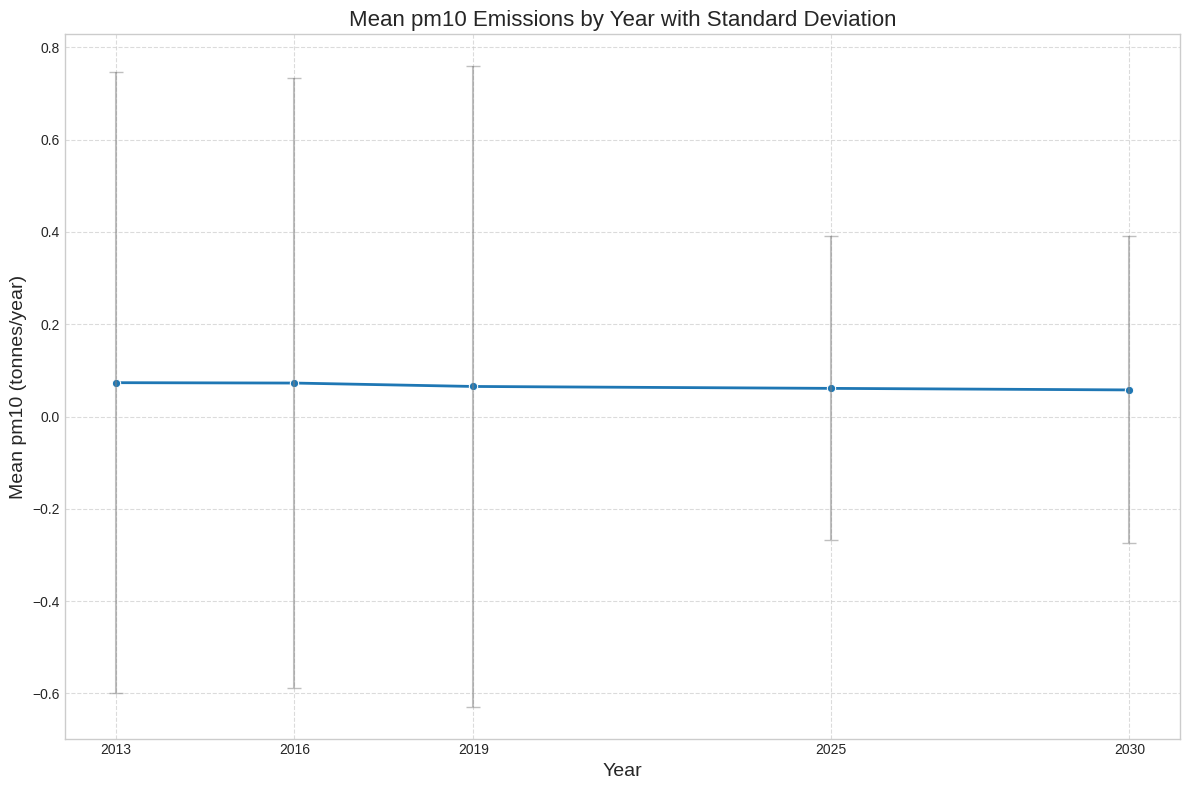


pm2.5 statistics by year:
   Year      mean    median       std  min        max
0  2013  0.036006  0.000295  0.168744  0.0  23.070241
1  2016  0.032461  0.000369  0.176274  0.0  23.070241
2  2019  0.028537  0.000462  0.172412  0.0  21.364992
3  2025  0.025398  0.000842  0.152918  0.0  19.908288
4  2030  0.023491  0.000824  0.146822  0.0  19.352226


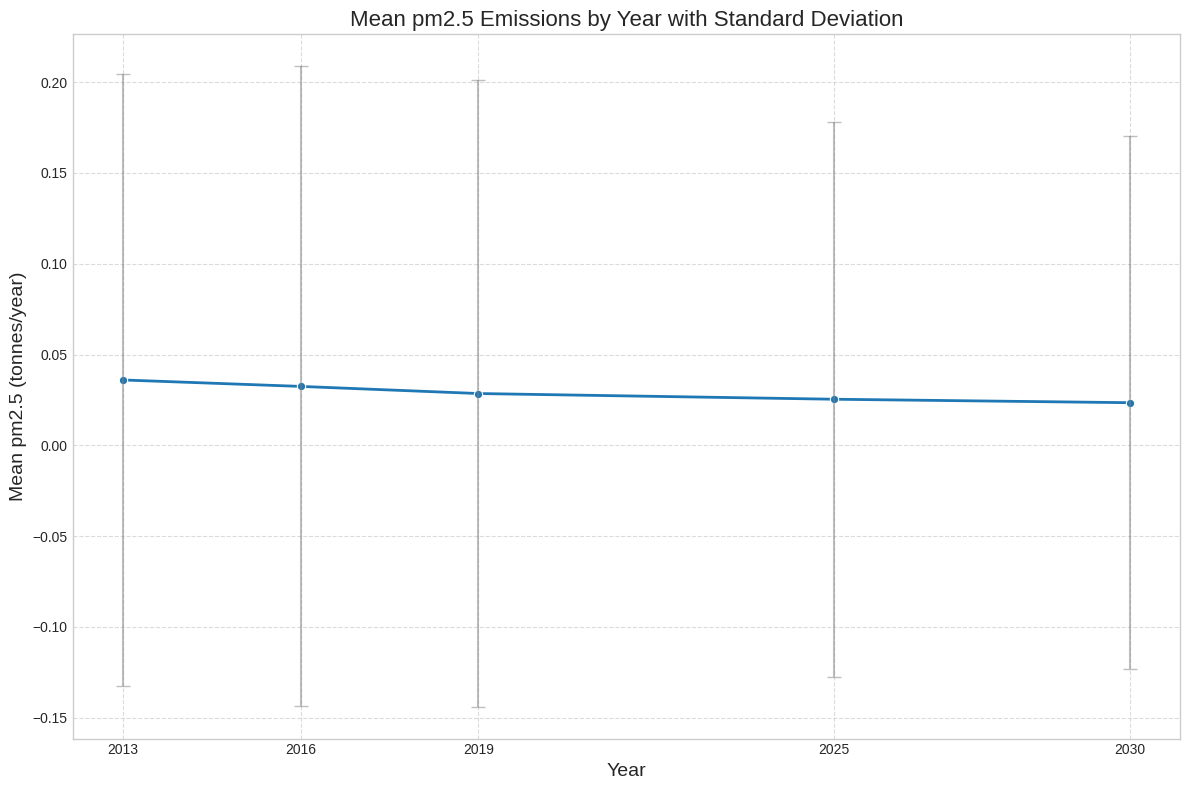


co2 statistics by year:
   Year        mean    median          std  min        max
0  2013  276.554848  0.687114  2540.680250  0.0   404000.0
1  2016  295.579986  0.687907  6342.606894  0.0  1764616.3
2  2019  257.580418  0.901680  3642.241790  0.0   747457.6
3  2025  247.696397  1.226029  3682.934906  0.0   747457.6
4  2030  219.058819  0.968910  3656.586493  0.0   747457.6


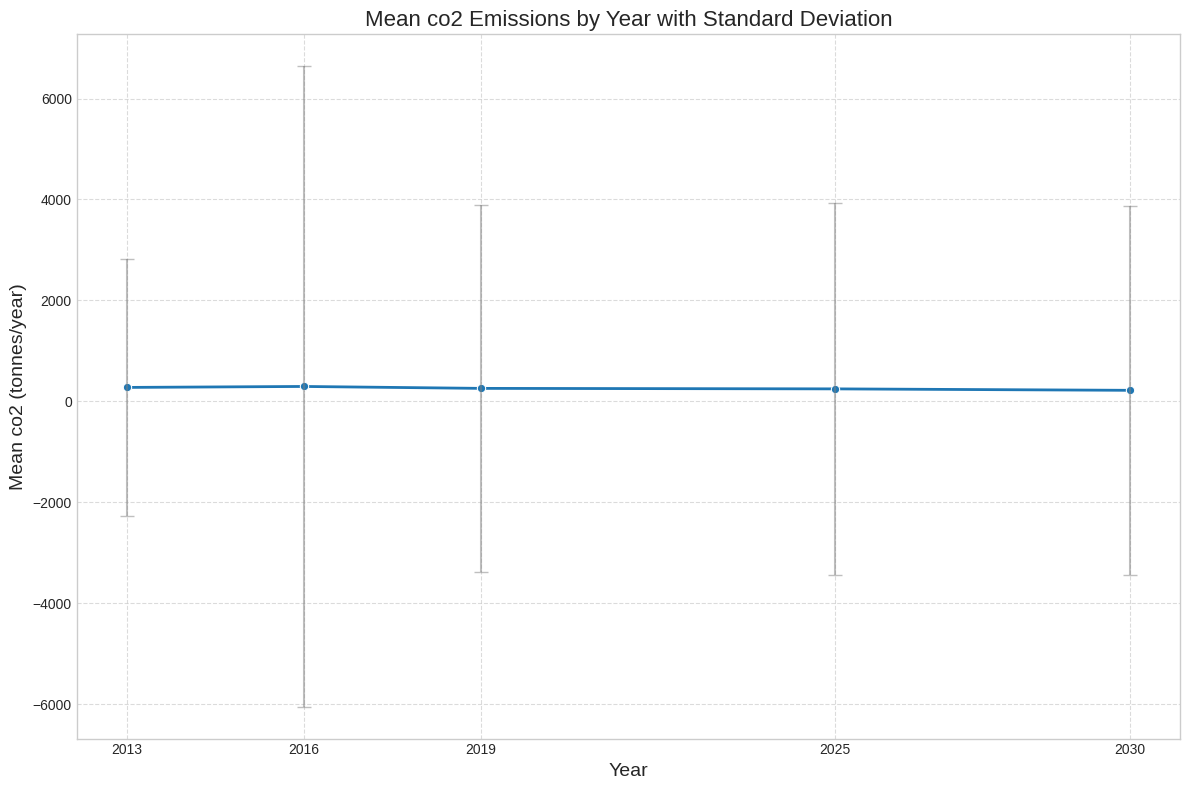

In [46]:
for pollutant in pollutants:
    analyze_pollutant_by_year(emission_data, pollutant)

The year-wise breakdown highlights some clear trends:

- **NOx emissions** show a steady decline in both mean and median values from 2013 to 2030, suggesting a likely improvements in air quality, might be due to stricter regulations or technological advancements. The high standard deviations indicate significant variability, especially in 2016.
- **PM10 and PM2.5** levels also decrease over time, with their means and medians dropping, and a reduction in max values after 2019; pointing to effective pollution controls.
- **CO2 emissions** are abit complex; the mean peaks in 2016, but the median remains quite low throughout, showing that extreme outliers (like the 1.76M max in 2016) heavily skew the data.

Overall, these stats reflect a consistent downward trend in emissions, but the exteme nature of CO2 and NOx data shows how localized high-emission zones (likely industrial areas or traffic hotspots) still contribute significantly.

### Pollutant analysis by zone 

In [48]:
def analyze_pollutant_by_zone(df, pollutant):
    data = df[~df[pollutant].isna()]
    
    #stats grouped by zone
    zone_stats = data.groupby('Zone')[pollutant].agg(['mean', 'median', 'std', 'count']).reset_index()
    print(f"\n{pollutant} statistics by zone:")
    print(zone_stats)
    
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Zone', y='mean', data=zone_stats)
    # error bars
    for i, row in zone_stats.iterrows():
        ax.errorbar(i, row['mean'], yerr=row['std'], fmt='none', capsize=5, ecolor='black')
    
    plt.title(f'Mean {pollutant} Emissions by Zone with Standard Deviation')
    plt.xlabel('Zone')
    plt.ylabel(f'Mean {pollutant} (tonnes/year)')
    plt.tight_layout()
    plt.show()


nox statistics by zone:
      Zone      mean    median       std   count
0  Central  0.927447  0.002400  4.290118   11136
1    Inner  0.508572  0.003631  4.118905  112732
2  Non GLA  0.264375  0.000180  2.444281  171844
3    Outer  0.344985  0.002000  5.605202  299944


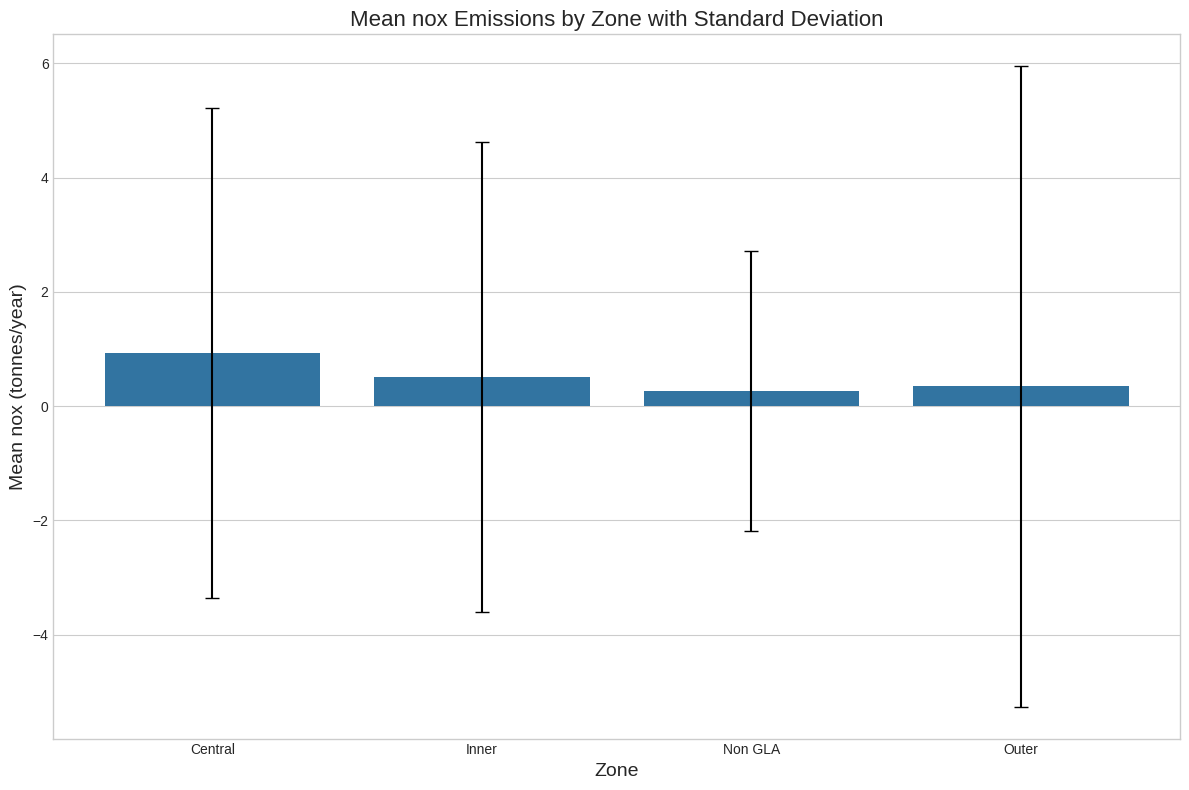


--------------------------


pm10 statistics by zone:
      Zone      mean    median       std   count
0  Central  0.157525  0.001433  0.966824   12736
1    Inner  0.101073  0.003183  0.735655  129026
2  Non GLA  0.041977  0.000215  0.241769  196683
3    Outer  0.062841  0.001179  0.594670  343375


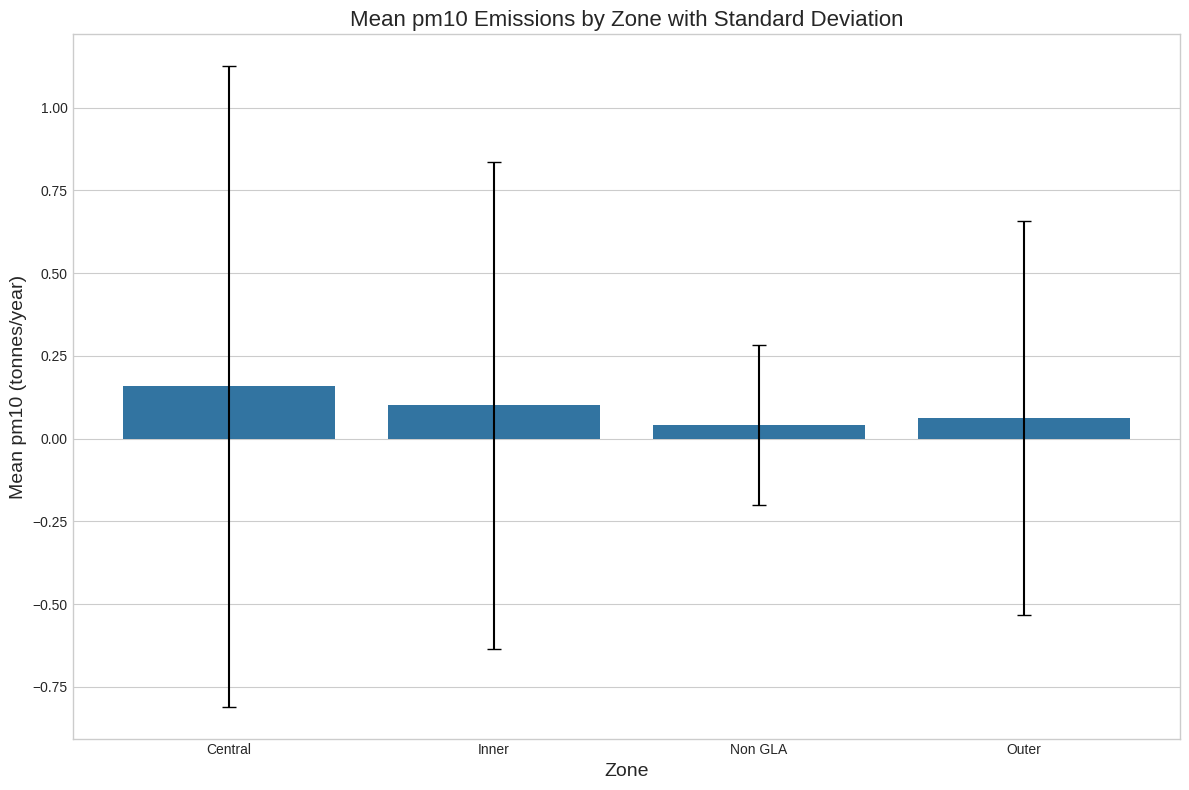


--------------------------


pm2.5 statistics by zone:
      Zone      mean    median       std   count
0  Central  0.083069  0.000886  0.648145   12736
1    Inner  0.043372  0.001583  0.198235  129026
2  Non GLA  0.017469  0.000126  0.095150  196683
3    Outer  0.028325  0.000722  0.132007  343375


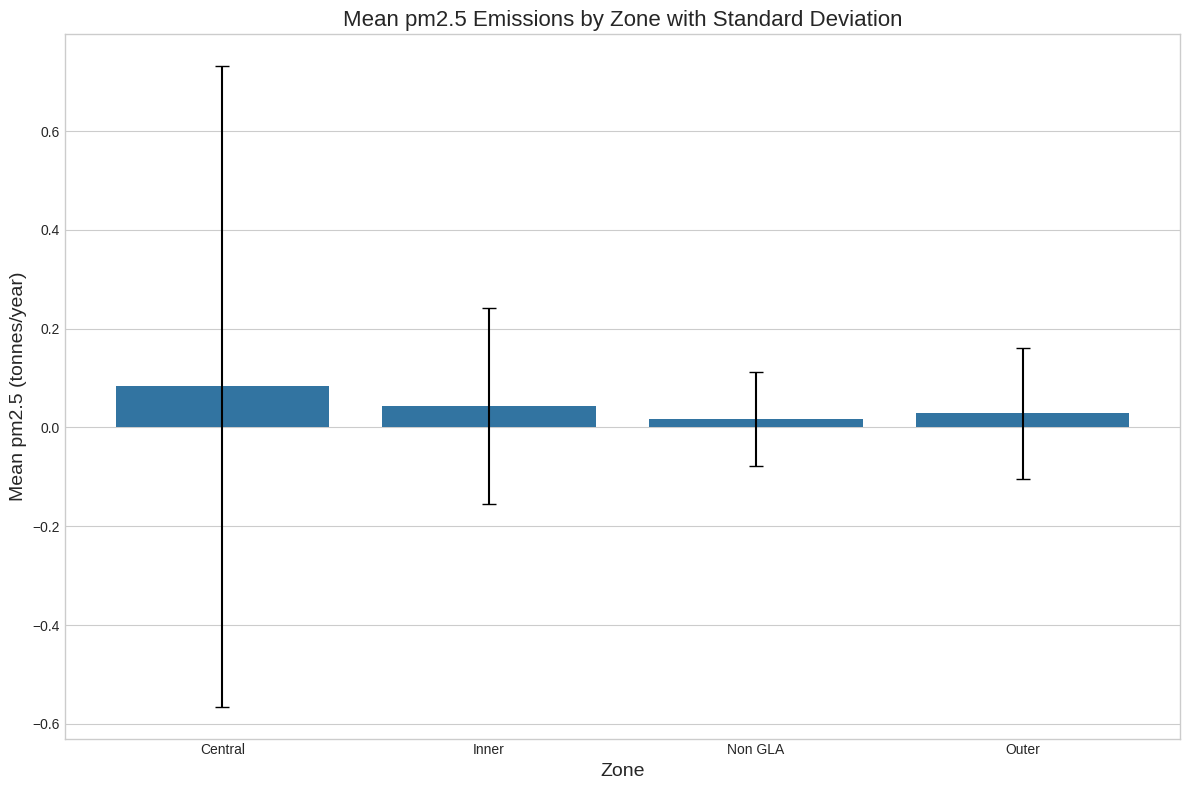


--------------------------


co2 statistics by zone:
      Zone        mean    median          std   count
0  Central  557.530310  1.034560  3029.210582   10048
1    Inner  380.678857  2.171381  3145.303829  101614
2  Non GLA  168.995994  0.375723  1854.232158  154895
3    Outer  253.419074  1.049043  5310.974359  270279


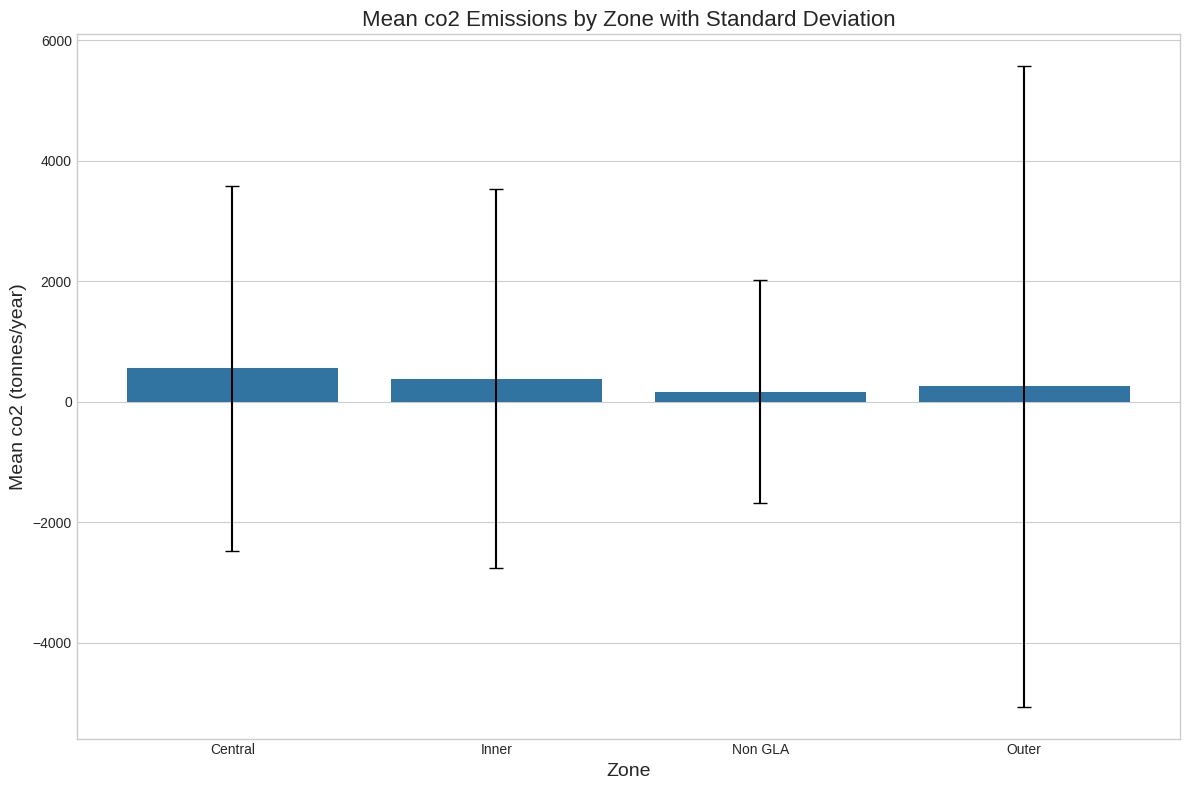


--------------------------



In [49]:
for pollutant in pollutants:
    analyze_pollutant_by_zone(emission_data, pollutant)
    print("\n--------------------------\n")

These zone-based breakdowns show some interesting patterns:

- **NOx:**  
  - **Central London** has the highest mean (0.93) and median (0.0024) NOx levels, likely due to high traffic density and commercial activity.  
  - **Outer zones** show lower means (0.34) but a wider spread (std = 5.6), suggesting the presence of occasional high-emission areas.  

- **PM10 & PM2.5:**  
  - Both particulates follow the same trend; 
       - **Central and Inner zones** show the highest concentrations, with **Outer and Non GLA zones** significantly cleaner.  
  - Medians in **Non GLA zones** are very low, hinting that air quality is generally better outside Greater London.  

- **CO2:**  
  - Again, **Central and Inner zones** top the charts, with **Central London** having an averge of **557.53**.  
  - The extreme **std for Outer zones (5310.97)** shows wide variation likely due to industrial reasons.  

### Pollutant analysis by main source category 

In [50]:
def analyze_pollutant_by_source(df, pollutant):
    data = df[~df[pollutant].isna()]
    
    source_stats = data.groupby('Main Source Category')[pollutant].agg(['mean', 'sum', 'count']).reset_index()
    source_stats = source_stats.sort_values('sum', ascending=False).head(10)
    
    print(f"\nTop 10 source categories for {pollutant} by total emissions:")
    print(source_stats)
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='sum', y='Main Source Category', data=source_stats)
    plt.title(f'Top Source Categories for {pollutant} Emissions')
    plt.xlabel(f'Total {pollutant} (tonnes/year)')
    plt.ylabel('Source Category')
    plt.tight_layout()
    plt.show()


Top 10 source categories for nox by total emissions:
        Main Source Category      mean            sum   count
3                  Transport  0.396623  133327.107737  336156
1  Industrial and Commercial  0.441175   68690.974009  155700
0                   Domestic  0.257689   13374.048884   51900
2              Miscellaneous  0.022653    1175.687538   51900


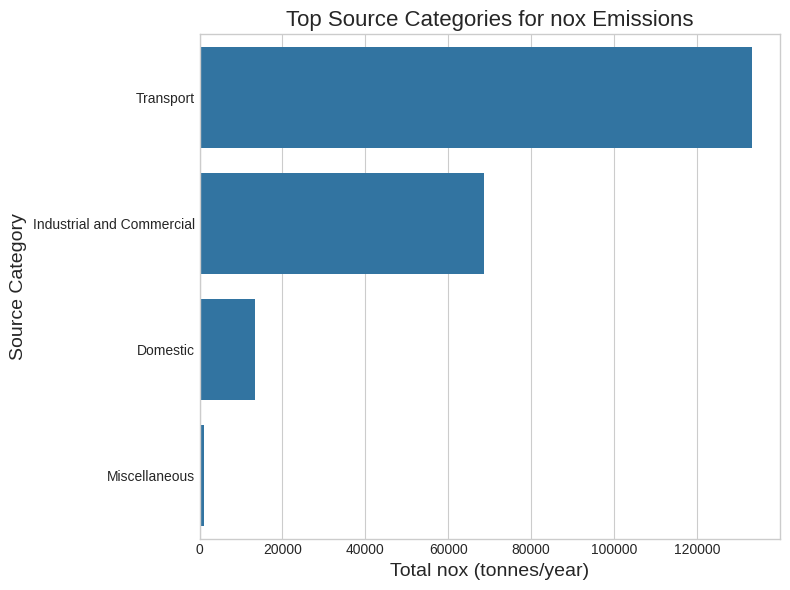


----------------------------------------


Top 10 source categories for pm10 by total emissions:
        Main Source Category      mean           sum   count
1  Industrial and Commercial  0.081448  16908.682502  207600
4                  Transport  0.039784  13373.748243  336156
3               Resuspension  0.533391   9048.448910   16964
0                   Domestic  0.071779   4967.115279   69200
2              Miscellaneous  0.011243    583.527095   51900


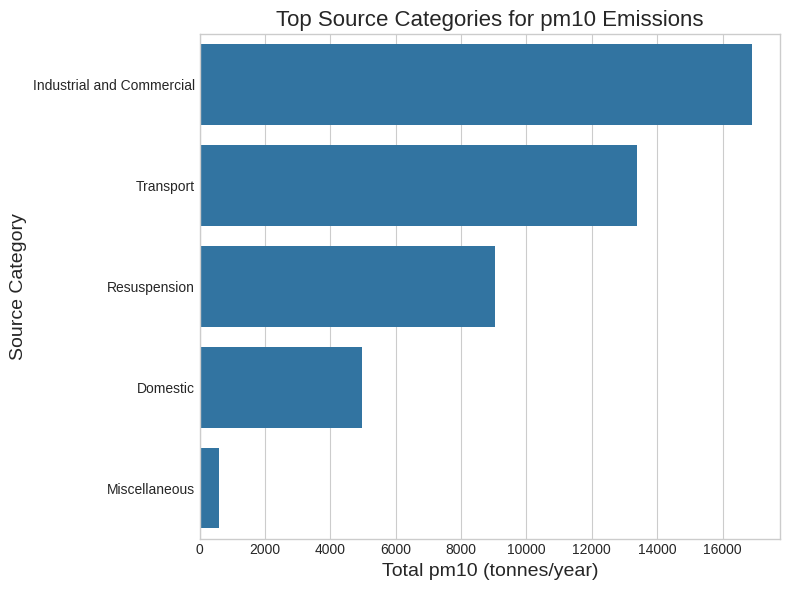


----------------------------------------


Top 10 source categories for pm2.5 by total emissions:
        Main Source Category      mean          sum   count
4                  Transport  0.021815  7333.353914  336156
1  Industrial and Commercial  0.032521  6751.448724  207600
0                   Domestic  0.071694  4961.215481   69200
2              Miscellaneous  0.008435   437.770167   51900
3               Resuspension  0.019585   332.231651   16964


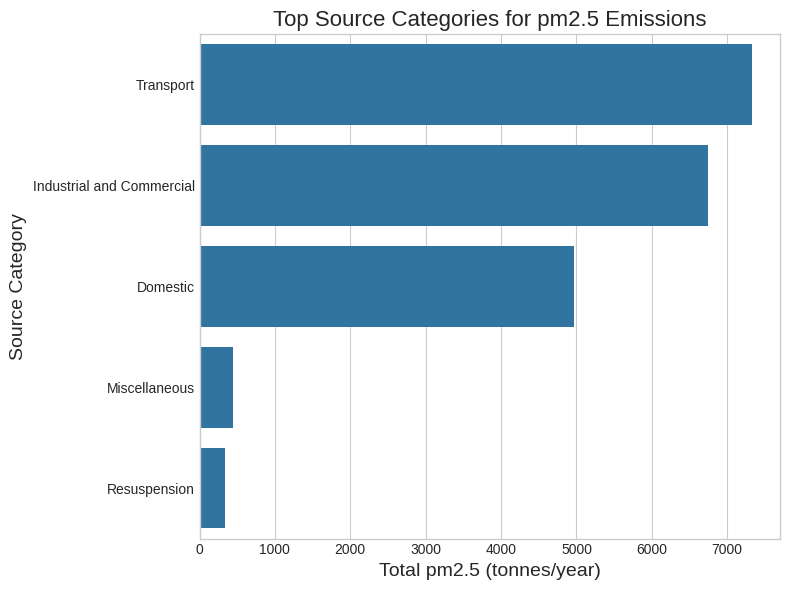


----------------------------------------


Top 10 source categories for co2 by total emissions:
        Main Source Category        mean           sum   count
3                  Transport  151.164853  5.081497e+07  336156
0                   Domestic  904.080219  4.692176e+07   51900
1  Industrial and Commercial  360.671060  4.118142e+07  114180
2              Miscellaneous    1.060612  3.669716e+04   34600


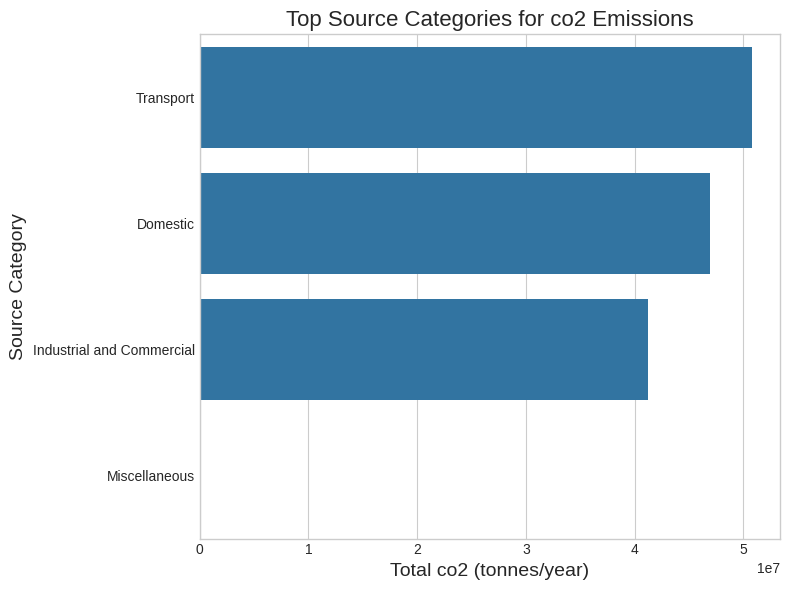


----------------------------------------



In [51]:
for pollutant in pollutants:
    analyze_pollutant_by_source(emission_data, pollutant)
    print("\n----------------------------------------\n")

- **NOx Emissions:**  
  - **Transport** is the dominant contributor, making up over **133,327** units; nearly **double** the next largest category.  
  - **Industrial and Commercial** sources follow, with a **avergae** higher than transport but a smaller overall count.  

- **PM10 Emissions:**  
  - **Industrial and Commercial** again lead the way, with **Resuspension** (dust from roads, construction etc.) making a notable contribution despite fewer records.  
  - **Transport** ranks second, highlighting the impact of vehicles on particulate pollution.  

- **PM2.5 Emissions:**  
  - **Transport** tops the list for **PM2.5** as well, slightly ahead of **Industrial and Commercial**; reflecting that smaller particulates are strongly linked to exhaust emissions.  

- **CO2 Emissions:**  
  - **Transport** is the largest source by far (over **50 million units**), but **Domestic** emissions are also high, possibly due to heating and power use.  
  - **Industrial and Commercial** sources also contribute heavily, though with a lower average levels than Domestic.  

### Pollutants correlation analysis

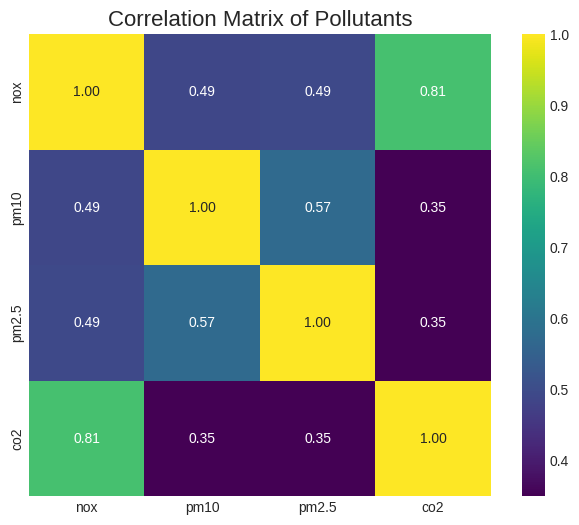

In [58]:
corr_matrix = emission_data[pollutants].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", square=True, cmap="viridis")
plt.title('Correlation Matrix of Pollutants')
plt.show()

We can analyze it as:

- **NOx and CO2:** Strong positive correlation (**0.81**), suggesting that sources emitting NOx (like transport and industrial activities) also release significant amounts of CO2. This makes sense since both are closely tied to combustion processes.

- **NOx and PM10/PM2.5:** Moderate correlation (**0.49**), indicating that while linked, these pollutants do not always co-occur; due to differences in their sources (e.g., PM can come from resuspension or other non-combustion sources).

- **PM10 and PM2.5:** Fairly strong correlation (**0.57**), reflecting their shared origins; both often stem from the same activities, though PM2.5 is typically more tied to exhaust and combustion, while PM10 includes coarser particles like road dust.

- **CO2 and PMs (PM10/PM2.5):** Weak correlations (**0.35**), showing that CO2-heavy sources do not always produce large amounts of particulates, possibly due to more modern, cleaner technologies or non-combustion-related PM sources.

### Explained Variance - Categorical Features

In [62]:
categorical_features = ['Borough', 'Zone', 'Main Source Category', 'Sector', 'Source']


Analyzing feature importance for nox:
Borough: 0.0018 variance explained
Zone: 0.0006 variance explained
Main Source Category: 0.0006 variance explained
Sector: 0.0035 variance explained
Source: 0.0108 variance explained


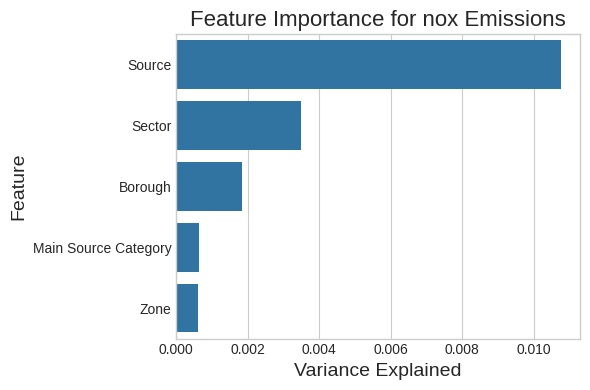


---------------------------------


Analyzing feature importance for pm10:
Borough: 0.0028 variance explained
Zone: 0.0018 variance explained
Main Source Category: 0.0193 variance explained
Sector: 0.0348 variance explained
Source: 0.0560 variance explained


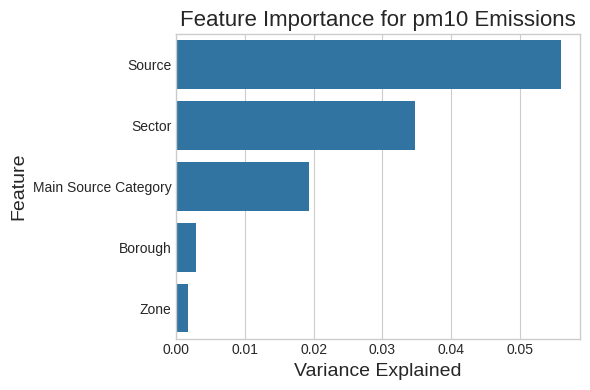


---------------------------------


Analyzing feature importance for pm2.5:
Borough: 0.0072 variance explained
Zone: 0.0049 variance explained
Main Source Category: 0.0093 variance explained
Sector: 0.0523 variance explained
Source: 0.0717 variance explained


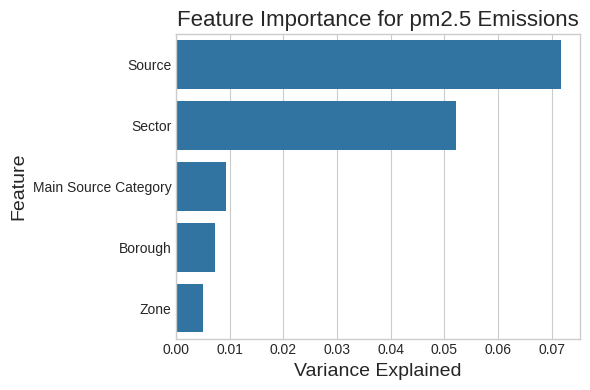


---------------------------------


Analyzing feature importance for co2:
Borough: 0.0008 variance explained
Zone: 0.0004 variance explained
Main Source Category: 0.0031 variance explained
Sector: 0.0056 variance explained
Source: 0.0139 variance explained


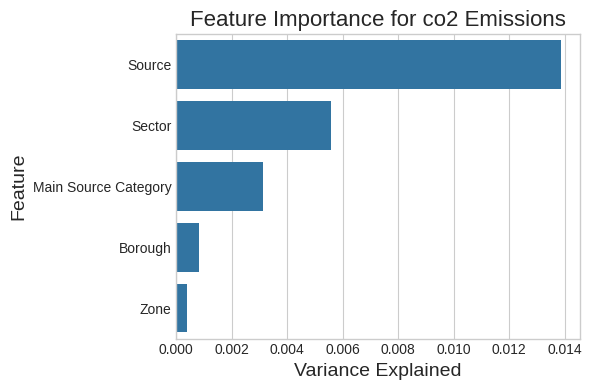


---------------------------------



In [64]:
for pollutant in pollutants:
    if pollutant in emission_data.columns:
        print(f"\nAnalyzing feature importance for {pollutant}:")

        #variance of pollutant by each feature
        variance_explained = {}

        for feature in categorical_features:
            #only condierig the data where both feature and pollutant are available
            feature_data = emission_data[~emission_data[pollutant].isna() & ~emission_data[feature].isna()]

            if len(feature_data) > 0:
                #total variance
                total_variance = feature_data[pollutant].var()

                #weighted variance within each group
                group_stats = feature_data.groupby(feature)[pollutant].agg(['var', 'count'])
                within_variance = (group_stats['var'] * (group_stats['count'] - 1)).sum() / (len(feature_data) - 1)

                #variance-explained = 1 - (within variance/total variance)
                if total_variance > 0:
                    explained = 1 - (within_variance / total_variance)
                    variance_explained[feature] = explained
                    print(f"{feature}: {explained:.4f} variance explained")
                else:
                    print(f"{feature}: Cannot calculate (zero total variance)")
                    

        if variance_explained:
            plt.figure(figsize=(6, 4))
            features = list(variance_explained.keys())
            values = list(variance_explained.values())

            sorted_indices = np.argsort(values)[::-1]
            features = [features[i] for i in sorted_indices]
            values = [values[i] for i in sorted_indices]

            sns.barplot(x=values, y=features)
            plt.title(f'Feature Importance for {pollutant} Emissions')
            plt.xlabel('Variance Explained')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()
            
        print("\n---------------------------------\n")

The feature importance analysis gives us a clear sense of what drives emissions for each pollutant:

- **NOx:**  
  - **Source** explains the most variance (**0.0108**), suggesting that fine-grained emissions sources (like specific transport or industrial activities) are more influential than broader categories.
  - **Sector** also plays a notable role (**0.0035**), while **Borough**, **Zone**, and **Main Source Category** explain far less variance.

- **PM10:**  
  - **Source** is again the dominant feature (**0.0560**), followed by **Sector** (**0.0348**).  
  - **Main Source Category** also has some weight (**0.0193**), aligning with transport and industrial contributions.

- **PM2.5:**  
  - **Source** leads with **0.0717** variance explained, and **Sector** follows closely at **0.0523**.  
  - There’s a higher role for **Borough** (**0.0072**) and **Zone** (**0.0049**) compared to NOx and CO2.

- **CO2:**  
  - **Source** is the most important factor (**0.0139**), though overall variance explained is lower across all features, likely because CO2 emissions stem from a wider variety of sources; especially transport and domestic sectors.  
  - **Main Source Category** and **Sector** show limited influence.

---